In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
import gc
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [2]:
data_reviews= pd.read_csv('C:\\Users\\Tati\\source\\repos\\acamica-datasets\\data_reviews.csv')

In [3]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
        
data_games = []
for l in parse('C:\\Users\\Tati\\source\\repos\\acamica-datasets\steam_games.json.gz'):
        data_games.append(l)

In [4]:
data_games = pd.DataFrame(data_games)

### DESCRIPCIÓN DE FEATURES DATA_REVIEWS
username: Nombre del usuario que ha dejado la reseña

hours: Cantidad de horas jugadas (acumuladas) en el juego al cual se le ha hecho la reseña

products: Cantidad de otros juegos probados

product_id: Identificacion númerica del juego reseñado

page_order: Número de página en el cual se encuentra el juego dentro de la plataforma

date: Fecha en la cual se ha creado la reseña

text: Comentario sobre el juego

early_access: Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

page: No es interpretable

user_id: Identificacion númerica del usuario creador de la reseña

found_funny: Cantidad de calificaciones positivas creadas por otros usuarios

compensation: Variable no interpretable dada la cantidad de valores nulos contenidos en ella

In [5]:
data_reviews.head()

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,7.656120e+16


### DESCRIPCIÓN DE FEATURES INCLUIDOS EN DATA_GAMES
desarrollador: Creador del juego

genres: Géneros, caracteristicas del juego

app_name: Editor del juego

title: Nombre del juego

url: Dirección web donde encontrarlo

release_date: Fecha de lanzamiento

tags: Etiquetas relacionadas con el juego

discount_price: Precio con descuento incluido

reviews_url: Dirección web donde encontrar las reseñas sobre el juego

specs: Especificaciones

price: Precio sin descuento

early_access: Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

id: Identificacion númerica del juego publicado

sentiment: Emoción promedio generada en los usuarios

metascore: Puntaje promedio recibido por los usuarios

In [6]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


### Analisis exploratorio DATA_REVIEWS

Vemos cantidad de filas, columns e informacion sobre cada feature

In [7]:
data_reviews.shape

(7793069, 13)

Data importante para definir los limites del analisis.

In [8]:
data_reviews.loc[:,['hours','products']].describe().round(2)

,hours,products
count,7766532.00,7778108.00
mean,111.84,236.48
std,392.86,485.79
min,0.00,1.00
25%,4.00,45.00
50%,15.30,110.00
75%,59.70,246.00
max,42100.70,18188.00


In [9]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7793069 entries, 0 to 7793068
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   username      object 
 2   hours         float64
 3   products      float64
 4   product_id    int64  
 5   page_order    int64  
 6   date          object 
 7   text          object 
 8   early_access  bool   
 9   page          int64  
 10  found_funny   float64
 11  compensation  object 
 12  user_id       float64
dtypes: bool(1), float64(4), int64(4), object(4)
memory usage: 720.9+ MB


Vemos los datos null

In [10]:
data_reviews.isna().sum()

Unnamed: 0            0
username            208
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text              17972
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

### De los DATOS analizados hay valores que no vamos a considerar, tales como:

* Usuarios con menos de 15 horas jugadas (falta de expertise)

* Usuarios con menos 30 juegos (falta de expertise)

* Usuarios que jugaron mas de 100 horas a un juego (exceso, claramente el juego le gusta)

* Usuarios que jugaron mas de 300 juegos. (es demasiado y se sale del perfil que queremos considerar)

In [11]:
data_reviews2=data_reviews[(data_reviews.products>15) & (data_reviews.products<300)]
data_reviews3=data_reviews2[(data_reviews2.hours>10) & (data_reviews2.hours<100)]
data_reviews3.dropna(subset=['text'], inplace=True)

<ipython-input-11-822659c5977a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reviews3.dropna(subset=['text'], inplace=True)


In [12]:
data_reviews3.drop("Unnamed: 0", axis=1, inplace=True)

C:\Users\Tati\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
data_reviews3.head(10)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
13,MR_SERENITY,14.8,147.0,35140,2,2018-01-03,aweosme game great story and some epic moments...,False,1,NaN,NaN,7.656120e+16
15,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
16,The Undead StalkeR,17.0,87.0,35140,5,2018-01-03,9/10\nEven after all these years. this game re...,False,1,NaN,NaN,7.656120e+16
32,Mono,14.1,54.0,506510,1,2017-12-27,A Charming game with colourful pixel graphics ...,False,1,NaN,NaN,7.656120e+16
39,xiodeni,18.4,18.0,35140,6,2018-01-03,I definitely recommend this game. I absolutely...,False,1,NaN,NaN,NaN
57,Uncle-Noob,24.7,37.0,350280,3,2018-01-04,"I really like this game, but no one plays it. ...",False,1,NaN,NaN,NaN
71,CatCookieHearT,12.7,211.0,620900,4,2017-06-25,I really enjoy Witchinour.\nThe dev says it co...,False,1,NaN,NaN,NaN
76,Aureus,13.2,260.0,506510,3,2017-12-26,Let's start with a very important statement: S...,False,1,NaN,NaN,NaN
83,WindySilver,11.2,75.0,431320,3,2016-06-04,"Edit: Having a good laptop for gaming now, I'v...",False,1,NaN,NaN,NaN
89,Bushi Neko,10.7,266.0,450230,0,2017-01-25,It is worth watching. Its not a great film. Bu...,False,1,NaN,NaN,7.656120e+16


Elimino aquellas instancias que no tengan usuario

In [14]:
empty_indexs=data_reviews3[data_reviews3.username.isna()].index
empty_indexs

Int64Index([  53571,   96741,  109254,  183052,  183278,  315025,  388952,
             526859,  585920, 1056356, 1265221, 1289050, 1296109, 1321800,
            1442146, 1594921, 1662447, 1749124, 1826167, 1926598, 1972583,
            2550455, 2602005, 2672712, 2795698, 2826345, 2963381, 3008927,
            3069909, 3132685, 3132717, 3635616, 3689605, 3751220, 3751330,
            3775656, 4031389, 4032479, 4207936, 4263776, 4514493, 4805527,
            4873973, 4908449, 4913661, 5036211, 5103461, 5613932, 5686884,
            5839502, 5852441, 5913225, 6007473, 6118408, 6142129, 6224486,
            6224686, 6264615, 6388567, 6567550, 6582504, 6582599, 6582667,
            6743015, 6979869, 6980071, 7063376, 7132887, 7133046, 7436788,
            7450747],
           dtype='int64')

In [15]:
data_reviews3.drop(empty_indexs,inplace=True)

C:\Users\Tati\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
data_reviews3.hours.isna().sum()

0

Filtro aquellas columnas que no considero utiles para le analisis

In [17]:
data_reviews4=data_reviews3.loc[:,['username','hours','products','product_id','text']]
data_reviews4.isna().sum()
del data_reviews3
data_reviews4

,username,hours,products,product_id,text
13,MR_SERENITY,14.8,147.0,35140,aweosme game great story and some epic moments...
15,Duha Nubie,11.3,73.0,35140,first debut feel sweet
16,The Undead StalkeR,17.0,87.0,35140,9/10\nEven after all these years. this game re...
32,Mono,14.1,54.0,506510,A Charming game with colourful pixel graphics ...
39,xiodeni,18.4,18.0,35140,I definitely recommend this game. I absolutely...
...,...,...,...,...,...
7793031,LostWhispers,92.1,150.0,252490,WARNING!! you will burn way to many hours in ...
7793032,Rick Sanchez C-132,63.0,37.0,252490,This game is already one of the most fun and i...
7793049,Crit_Magnet_,16.0,192.0,252490,"So much fun, once you get set up!"
7793061,worldoftanks,82.2,91.0,252490,O yes good waiting long time


Realizamos algunos graficos para ver la distribucion de algunas variables

<AxesSubplot:xlabel='products'>

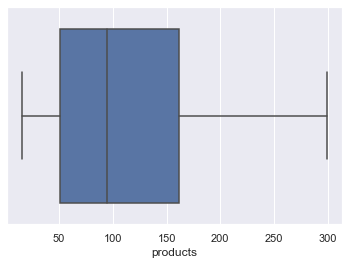

In [18]:
sns.boxplot(x = data_reviews4.products)

<AxesSubplot:xlabel='hours'>

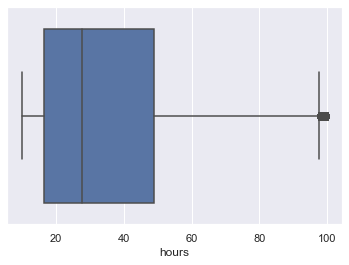

In [19]:
sns.boxplot(x = data_reviews4.hours)

In [20]:
data_reviews4.products

13         147.0
15          73.0
16          87.0
32          54.0
39          18.0
           ...  
7793031    150.0
7793032     37.0
7793049    192.0
7793061     91.0
7793066    288.0
Name: products, Length: 2313124, dtype: float64

<AxesSubplot:xlabel='products', ylabel='Density'>

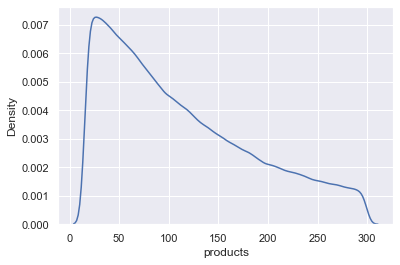

In [21]:
sns.kdeplot(data=data_reviews4.products)

<AxesSubplot:xlabel='hours', ylabel='Density'>

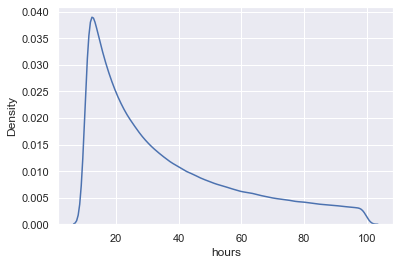

In [22]:
sns.kdeplot(data=data_reviews4.hours)

#### Para completar el analisis exploratorio de data_reviews:

In [23]:
data_reviews4.username.value_counts().mean()

2.147308813427155

1. Que cantidad de reviews deja en promedio cada usuario?

In [24]:
reviews_prom=data_reviews4.username.value_counts().mean()
print(f'El promedio de reviews por usuario es:{reviews_prom}')

El promedio de reviews por usuario es:2.147308813427155


2. Dentro de los limites establecidos, cuales son los usuarios que mas reviews dejaron?


In [25]:
data_reviews4['username'].value_counts()[0:15].index.tolist()

['Alex',
 '123',
 'Chris',
 'Red',
 'Ghost',
 'Sam',
 'Jack',
 'Nick',
 'Dan',
 'Tom',
 'Matt',
 'Wolf',
 'John',
 'ุ',
 'James']

3. Dentro de los limites establecidos, cuales son los usuarios que menos reviews dejaron?

In [26]:
data_reviews4['username'].value_counts()[-15:-1].index.tolist()

['tylerc1101',
 'ktulu',
 'BaraZard',
 'BritGamer98',
 'hussar',
 'Hiphopoptamus-',
 'Cpt_Poop_Stain',
 'SmokingDutchman',
 'ArtMeister',
 'Sera セラ',
 'Rum&Gin',
 'Rolodecks68',
 'RuinSmith',
 'Décke Schwësteren']

4. Cual es el juego que mas reviews tuvo? cual el que menos reviews tuvo?

In [27]:
data_reviews4.product_id.mode()

0    391540
dtype: int64

In [28]:
data_reviews4.username.value_counts().describe()

count    1.077220e+06
mean     2.147309e+00
std      3.932663e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.750000e+02
Name: username, dtype: float64

(0.0, 10.0)

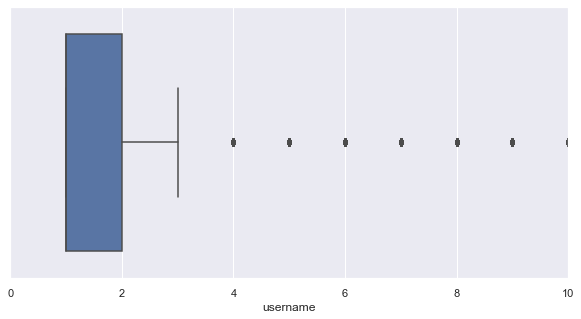

In [29]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x=data_reviews4.username.value_counts())
ax.set_xlim([0,10])

A continuación determino por medio de TextBlob, la polaridad de un review analizando la variable Text.
La Polaridad es un número décimal que oscila entre -1 y 1, donde 1 significa que el comentario transmite un sentimiento positivo y, -1 un sentimiento negativo

In [30]:
len(data_reviews4.text)

2313124

In [31]:
polarity_list=[]
exceptions=[]
for i in range(len(data_reviews4.text)):
    frase=TextBlob(data_reviews4.text.iloc[i])
    polarity=frase.sentiment.polarity
    polarity_list.append(polarity)

In [74]:
len(exceptions)

0

In [75]:
data_reviews4['Polarity']=pd.Series(polarity_list)

In [76]:
data_reviews4.head()

,username,hours,products,product_id,text,Polarity,Calif
13,MR_SERENITY,14.8,147.0,35140,aweosme game great story and some epic moments...,0.000000,1
15,Duha Nubie,11.3,73.0,35140,first debut feel sweet,0.800000,3
16,The Undead StalkeR,17.0,87.0,35140,9/10\nEven after all these years. this game re...,0.075000,1
32,Mono,14.1,54.0,506510,A Charming game with colourful pixel graphics ...,-0.017647,1
39,xiodeni,18.4,18.0,35140,I definitely recommend this game. I absolutely...,0.000000,1


In [77]:
correlation=data_reviews4.loc[:,['hours','products','Polarity']].corr()
correlation

,hours,products,Polarity
hours,1.000000,-0.038893,-0.002410
products,-0.038893,1.000000,-0.000133
Polarity,-0.002410,-0.000133,1.000000


<AxesSubplot:>

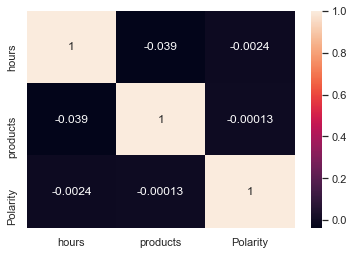

In [78]:
sns.heatmap(correlation, cbar = True,annot = True)

No existe ninguna relación linal entre un comentario positivo dejado por el usuario a un juego y la cantidad de horas jugadas, ni otros juegos probados. Concluimos en que la relación es bivariable y por ende, no apreciable en el heatmap.

In [79]:
data_reviews4.loc[:,['hours','products','Polarity']].describe().round(2)

,hours,products,Polarity
count,2313124.00,2313124.00,699132.00
mean,35.51,112.70,0.12
std,23.26,74.22,0.27
min,10.10,16.00,-1.00
25%,16.60,51.00,0.00
50%,27.70,95.00,0.10
75%,49.00,162.00,0.25
max,99.90,299.00,1.00


Criterio determinacion de Score: 
* Si la cantidad de productos está dentro de los valores del primer cuartil y la cantidad de horas jugadas es mayor al 75% de los valores de la muestra---> Calificación positiva (corroborado con el indice de polaridad)

* Si la cantidad de productos es mayor al 75% de los valores contenidos en la muestra y la cantidad de horas jugadas está dentro del primer 25% de los valores---> Calificación negativa (corroborado con el índice de polaridad)

In [80]:
positive_mask= (data_reviews4.hours>48) & (data_reviews4.products<55)

In [81]:
data_reviews4[positive_mask].Polarity.mean()

0.12253171446669622

El resultado obtenido es considerado suficiente para determinar como minimo de polaridad con la que un usuario calificaría como positivo al juego ya que, 0.13 es mayor al promedio de polaridad y, dado que la polaridad es un número que oscila entre -1 y 1 siendo -1 negativo y 1 positvo, el valor obtenido se encuentra mas cercano al extremo positivo que al extremo negativo

In [82]:
negative_mask=(data_reviews4.hours<16) & (data_reviews4.products>166)
data_reviews4[negative_mask].head()

,username,hours,products,product_id,text,Polarity,Calif
71,CatCookieHearT,12.7,211.0,620900,I really enjoy Witchinour.\nThe dev says it co...,-0.102174,1
76,Aureus,13.2,260.0,506510,Let's start with a very important statement: S...,-0.050000,1
89,Bushi Neko,10.7,266.0,450230,It is worth watching. Its not a great film. Bu...,0.196237,3
132,Friz,14.0,219.0,506510,Basically Final Fantasy Mystic Quest 2,0.154702,3
174,drzendoom,15.9,272.0,8880,Managed to get it to work by setting the exe t...,0.126923,2


In [41]:
data_reviews4[negative_mask].Polarity.mean()

0.1238445383450159

In [42]:
undefined_mask=(data_reviews4.Polarity<0.13117870234093953) & (data_reviews4.Polarity>0.0567740481140225)

In [43]:
data_reviews4[positive_mask]

,username,hours,products,product_id,text,Polarity
566,Mky,64.4,45.0,1840,It's a lot of fun if you know what you're doin...,-0.088372
592,Kachigga,69.9,23.0,1840,Quite difficult to learn to use but after a co...,-0.400000
662,SwaggerBallz,55.2,31.0,8880,I wish Steam would patch this game. I always e...,0.000000
745,Bricks04,73.9,32.0,1840,"Great tool, renders are crisp and resemble the...",0.066667
806,DatGuyT_T,94.5,46.0,1840,Very good best of all its free but REALLY need...,0.295089
...,...,...,...,...,...,...
7792522,Cloud,65.2,50.0,252490,EPIC !,NaN
7792609,Haetcher upgrader.gg,93.8,51.0,252490,The game is cool only it laagt extremely chopp...,NaN
7792665,Testikills,79.4,19.0,252490,Joke of a dev team. Usually I try not to buy e...,NaN
7792726,]TDF[Gomer,91.4,43.0,252490,In the day and age were Dayz/Minecraft clones ...,NaN


In [44]:
calif_pos=data_reviews4[positive_mask].shape[0]/data_reviews4.shape[0]
print(f'El {calif_pos*100}% de las reviews son positivas')

El 7.533664429576624% de las reviews son positivas


In [45]:
def conditions(data):
    if (data['Polarity'] > 0.13175401820734617):
        return 3
    elif (data['Polarity'] < 0.11806886378669548):
        return 1
    else:
        return 2

In [46]:
data_reviews4['Calif'] = data_reviews4.apply(conditions, axis=1)

In [47]:
data_reviews4.head()

,username,hours,products,product_id,text,Polarity,Calif
13,MR_SERENITY,14.8,147.0,35140,aweosme game great story and some epic moments...,0.000000,1
15,Duha Nubie,11.3,73.0,35140,first debut feel sweet,0.800000,3
16,The Undead StalkeR,17.0,87.0,35140,9/10\nEven after all these years. this game re...,0.075000,1
32,Mono,14.1,54.0,506510,A Charming game with colourful pixel graphics ...,-0.017647,1
39,xiodeni,18.4,18.0,35140,I definitely recommend this game. I absolutely...,0.000000,1


### Analisis exploratorio Data Games

In [48]:
data_games['title'].unique().shape

(30055,)

In [49]:
data_games[data_games.id=="35140"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [50]:
data_games.drop_duplicates(subset ="id",
                     keep = False, inplace = True)

In [51]:
data_games[data_games.id=="35140"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [52]:
data_games.shape

(32131, 16)

In [53]:
data_games.id.unique().size

32131

In [54]:
url_splited = data_games.url.str.split('/')
url_splited

0        [http:, , store.steampowered.com, app, 761140,...
1        [http:, , store.steampowered.com, app, 643980,...
2        [http:, , store.steampowered.com, app, 670290,...
3        [http:, , store.steampowered.com, app, 767400,...
4        [http:, , store.steampowered.com, app, 773570,...
                               ...                        
32130    [http:, , store.steampowered.com, app, 773640,...
32131    [http:, , store.steampowered.com, app, 733530,...
32132    [http:, , store.steampowered.com, app, 610660,...
32133    [http:, , store.steampowered.com, app, 658870,...
32134    [http:, , store.steampowered.com, app, 681550,...
Name: url, Length: 32131, dtype: object

In [168]:
resultados = []
data_games["URL_NAME"] = "empty"
k=0
m = 5
for i in url_splited:
    data_games["URL_NAME"].iloc[k] = i[m]
    resultados.append(i[5])
    k=k+1
k=0

C:\Users\Tati\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [169]:
resultados

['Lost_Summoner_Kitty',
 'Ironbound',
 'Real_Pool_3D__Poolians',
 '2222',
 'Log_Challenge',
 'Battle_Royale_Trainer',
 'SNOW__All_Access_Basic_Pass',
 'SNOW__All_Access_Pro_Pass',
 'SNOW__All_Access_Legend_Pass',
 'Race',
 'Uncanny_Islands',
 'Icarus_Six_Sixty_Six',
 'Army_of_Tentacles_Not_A_Cthulhu_Dating_Sim_Black_GOAT_of_the_Woods_Edition',
 'Beach_Rules',
 'Planetarium_2__Zen_Odyssey',
 'The_first_thrust_of_God',
 'SNOW__Starter_Pack',
 'The_first_thrust_of_God__All_Aircrafts',
 'SNOW__Lifetime_Pack',
 'After_Life_VR',
 'Kitty_Hawk',
 'The_Warrior_Of_Treasures',
 'Mortars_VR',
 'RC_Plane_3__Canyon_Scenario',
 'RC_Plane_3__F53B',
 'DinoBlaster',
 'Robotpencil_Presents_Understanding_3D_for_Concept',
 'Carmageddon_Max_Pack',
 'HalfLife',
 'Fallen_Mage',
 'Dont_Get_Hit_In_The_Face',
 'Lost_Cities',
 'Twisted_Enhanced_Edition',
 'Vaporwave_Simulator',
 'Tactics_Forever',
 'Christmas_Santa_Troubles',
 'Kingdom_Watcher',
 'Underdone__Soundtrack',
 'Bitcoin_Clicker',
 'Disciples_II_Gallean

In [170]:
##data_games.drop(['title'],inplace=True,axis=1)

In [171]:
data_games[data_games.id=="35140"]
data_games[data_games.URL_NAME.isna()]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,URL_NAME,price_


In [172]:
data_games.early_access.value_counts()
print( f'El {1947/(30184+1947)*100}% son juegos que permiten ser probados antes de su lanzamiento ')

El 6.059568640876412% son juegos que permiten ser probados antes de su lanzamiento 


In [173]:
data_games['price'].fillna('null',inplace=True)

In [174]:
data_games['price_']=data_games['price']

In [175]:
data_games['price_']

0                4.99
1        Free To Play
2        Free to Play
3                0.99
4                2.99
             ...     
32130            1.99
32131            4.99
32132            1.99
32133            4.99
32134            4.99
Name: price_, Length: 32131, dtype: object

In [176]:
k=0
for y in data_games.price_:
    if(isinstance(y, str)):
        if (y.find('Starting')!=-1):
            data_games.price_[k]=y.split(' ')[-1]
            data_games.price_[k]= float(data_games.price_[k].replace("$", ""))
        else:
            data_games.price_[k]=0.00
    k=k+1

<ipython-input-176-3c5953ea5c20>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games.price_[k]=0.00
<ipython-input-176-3c5953ea5c20>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games.price_[k]=y.split(' ')[-1]
<ipython-input-176-3c5953ea5c20>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games.price_[k]= float(data_games.price_[k].replace("$", ""))


In [177]:
data_games.price_.unique()

array([4.99, 0.0, 0.99, 2.99, 3.99, 9.99, 18.99, 29.99, 10.99, 1.59,
       14.99, 1.99, 59.99, 8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 'null',
       12.99, 5.99, 2.49, 'Free', 1.25, 'Free to Play', 24.99, 17.99,
       61.99, 3.49, 11.99, 13.99, 'Free Demo', 'Play for Free!', 74.76,
       1.49, 32.99, 99.99, 14.95, 69.99, 16.99, 79.99, 49.99, 5.0, 44.99,
       13.98, 'Free To Play', 15.99, 34.99, 29.96, 119.99, 109.99, 149.99,
       'Install Now', 21.99, 89.99, 'Play WARMACHINE: Tactics Demo',
       139.92, 4.29, 64.99, 'Free Mod', 54.99, 74.99, 'Install Theme',
       0.89, 'Third-party', 0.5, 'Play Now', 1.29, 3.0, 15.0, 5.49, 23.99,
       49.0, 20.99, 10.93, 1.39, 'Free HITMAN™ Holiday Pack', 36.99, 4.49,
       2.0, 4.0, 234.99, 1.95, 1.5, 199.0, 189.0, 6.66, 27.99, 10.49,
       129.99, 179.0, 26.99, 399.99, 31.99, 399.0, 20.0, 40.0, 3.33,
       199.99, 22.99, 320.0, 38.85, 71.7, 59.95, 995.0, 3.39, 19.95,
       499.99, 16.06, 4.68, 131.4, 202.76, 1.0, 2.3, 0.95, 172.24, 29

In [178]:
data_games2=data_games.loc[:,['URL_NAME','id']]
data_games2[data_games2.URL_NAME.isna()]

,URL_NAME,id


In [179]:
type(data_games.price_.iloc[14])

float

In [180]:
#plt.figure(figsize=(20, 10))
#sns.boxplot(x=data_games.precie_[data_games.precie_<399])

In [181]:
data_games2.id=pd.to_numeric(data_games2.id,downcast='integer')

In [182]:
data_games2[data_games2.id==35140]

,URL_NAME,id
31617,Batman_Arkham_Asylum_Game_of_the_Year_Edition,35140


In [183]:
data_reviews4

,username,hours,products,product_id,text,Polarity,Calif
13,MR_SERENITY,14.8,147.0,35140,aweosme game great story and some epic moments...,0.000000,1
15,Duha Nubie,11.3,73.0,35140,first debut feel sweet,0.800000,3
16,The Undead StalkeR,17.0,87.0,35140,9/10\nEven after all these years. this game re...,0.075000,1
32,Mono,14.1,54.0,506510,A Charming game with colourful pixel graphics ...,-0.017647,1
39,xiodeni,18.4,18.0,35140,I definitely recommend this game. I absolutely...,0.000000,1
...,...,...,...,...,...,...,...
7793031,LostWhispers,92.1,150.0,252490,WARNING!! you will burn way to many hours in ...,NaN,2
7793032,Rick Sanchez C-132,63.0,37.0,252490,This game is already one of the most fun and i...,NaN,2
7793049,Crit_Magnet_,16.0,192.0,252490,"So much fun, once you get set up!",NaN,2
7793061,worldoftanks,82.2,91.0,252490,O yes good waiting long time,NaN,2


In [189]:
data_to_export = pd.merge(data_reviews4, data_games2, left_on='product_id', right_on='id', how='left').drop('id', axis=1)
data_unique = data_to_export[data_to_export.URL_NAME.isna() | data_to_export.URL_NAME=="empty" ].drop_duplicates(subset="product_id")

In [191]:
data_to_export[data_to_export.URL_NAME == "empty"]

,username,hours,products,product_id,text,Polarity,Calif,URL_NAME


In [187]:
#data_to_export.drop(['text'],inplace=True,axis=1)
#data_to_export

In [188]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,URL_NAME,price_
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN,Lost_Summoner_Kitty,4.99
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN,Ironbound,0.0
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN,Real_Pool_3D__Poolians,0.0
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN,2222,0.99
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN,Log_Challenge,2.99


In [73]:
data_to_export.to_csv('C:\\Users\\Tati\\source\\repos\\data_full.csv')